# Configuration

In [1]:
# Parameters
ENABLE_COLAB = False

PROJECT_NAME = 'ML1010-Group-Project'
EXPERIMENT_NAME = 'ReviewText_Lemma_Bert2 (LSTM)'
FILE_NAME = '01_ML1010_GP_LSTM_Bert2_scratch'
LOAD_FROM_EXP = False

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
COLAB_ROOT_DIR = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
COLAB_INIT_DIR = COLAB_ROOT_DIR + '/utility_files'

LOCAL_ROOT_DIR = '/home/magni//ML_Root/project_root'
LOCAL_INIT_DIR = LOCAL_ROOT_DIR + '/utility_files'

# Bootstrap Environment

In [2]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  INIT_DIR = COLAB_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = COLAB_ROOT_DIR
  
else:
  #add in utility directory to syspath to import
  INIT_DIR = LOCAL_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = LOCAL_ROOT_DIR

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ROOT_DIR, PROJECT_NAME)

import mv_python_utils as mvutils

Wha...where am I?
I am awake now.

I have set your current working directory to /home/magni/ML_Root/project_root/ML1010-Group-Project
The current time is 19:53
Hello sir. I hope you had dinner.



# Setup Runtime Environment

In [3]:
if ENABLE_COLAB:
  #!pip install scipy -q
  #!pip install scikit-learn -q
  #!pip install pycaret -q
  #!pip install matplotlib -q
  #!pip install joblib -q
  #!pip install pandasql -q
  !pip install umap_learn -q
  !pip install sentence_transformers -q
  !pip install spacytextblob -q
  !pip install flair -q
  display('Google Colab enabled')
else:
  display('Google Colab not enabled')

#Common imports
import json
import pandas as pd
import numpy as np
import matplotlib
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split as tts
#from yellowbrick.classifier import ConfusionMatrix
#from sklearn.linear_model import LogisticRegression
from yellowbrick.target import ClassBalance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

nltk.download('stopwords')
%matplotlib inline

'Google Colab not enabled'

[nltk_data] Downloading package stopwords to /home/magni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import cw_df_metric_utils as cwutils
import importlib
import DataPackage as dp
import DataPackageSupport as dps
import DataExperiment
import DataExperimentSupport as des

2022-01-22 19:53:42.071072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-22 19:53:42.071108: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data

In [5]:
#axis_labels=[1,2,3,4,5]
axis_labels=[0,1]

# using a dummyclassifier as DataExperiment requires a classifier to load
# and doesn't fully support Tensorflow models yet
classifier = DummyClassifier()
ANALYSIS_COL = 'reviewText_lemma_bert'
UNIQUE_COL = 'uuid'
TARGET_COL = 'overall_posneg'

In [12]:
if LOAD_FROM_EXP:
    #start from saved state
    myExp = jarvis.loadExperiment(FILE_NAME)
    myExp.display()

else:
    #start from source file and regenerate
    testDf = pd.read_pickle(jarvis.DATA_DIR_WORK + "/01_NL_ReviewText_All(new).pkl.gz")

    testDfBert = cwutils.getBertEncodeFrame(df=testDf,
                                            bertColumn=ANALYSIS_COL,
                                            uniqueColumn=UNIQUE_COL,
                                            otherColumns=[TARGET_COL]
                                            )
  
    myExp = DataExperiment.DataExperiment(projectName=PROJECT_NAME,
                                          experimentName=EXPERIMENT_NAME,
                                          origData=testDfBert,
                                          uniqueColumn=UNIQUE_COL,
                                          targetColumn=TARGET_COL,
                                          classifier=classifier)

DataExperiment summary:
---> projectName: ML1010-Group-Project
---> experimentName: ReviewText_Lemma_Bert2 (LSTM)
---> isDataPackageLoaded: True
---> isBaseModelLoaded: False
---> isBaseModelPredicted: False
---> isBaseModelLearningCurveCreated: False
---> isFinalModelLoaded: False
---> isFinalModelPredicted: False
---> isFinalModelLearningCurveCreated: False
---> isClassifierLoaded: True
DummyClassifier()

    DataPackage summary:
    Attributes:
    ---> uniqueColumn: uuid
    ---> targetColumn: overall_posneg
    Process:
    ---> isBalanced: False
    ---> isTrainTestSplit: False
    Data:
    ---> isOrigDataLoaded: True
    ---> isTrainDataLoaded: False
    ---> isTestDataLoaded: False


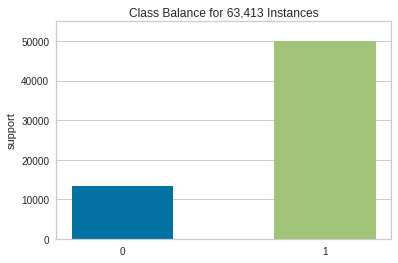

,overall_posneg,ttlCol
0,0,13440
1,1,49973


In [13]:
#get the train data and downsample to 2900
tDf = myExp.dataPackage.getOrigData()
dps.displayClassBalance(tDf, myExp.dataPackage.targetColumn, verbose=True)

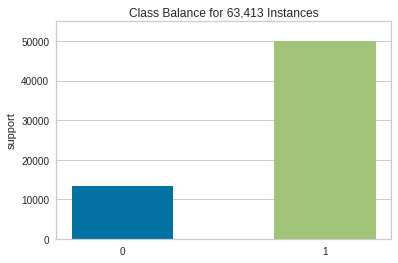

Undersampling data to match min class: 0 of size: 13440


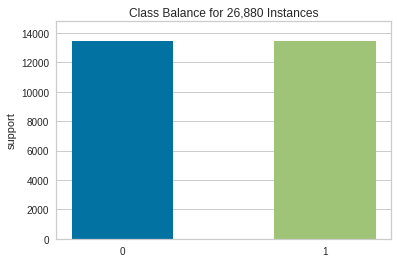

,overall_posneg,ttlCol
0,0,13440
1,1,13440


Completed train/test split (train_size = 0.8):
---> Original data size: 26880
---> Training data size: 21504
---> Testing data size: 5376
---> Stratified on column: overall_posneg


In [14]:
myExp.dataPackage.classBalanceUndersample()
myExp.dataPackage.splitTrainTest()

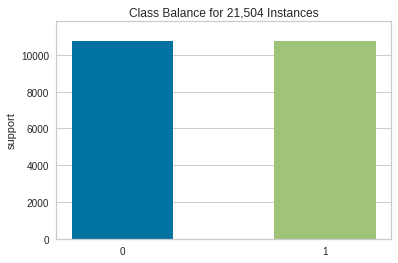

,overall_posneg,ttlCol
0,0,10752
1,1,10752


In [15]:
tDf2 = myExp.dataPackage.getTrainData()
dps.displayClassBalance(tDf2, myExp.dataPackage.targetColumn, verbose=True)

In [16]:
SAMPLE_DOWN_SIZE=10700
# Do the sampling
tDf2 = tDf2.groupby(myExp.dataPackage.targetColumn, group_keys=False).apply(lambda x: x.sample(SAMPLE_DOWN_SIZE))
tDf2.reset_index(drop=True, inplace=True)

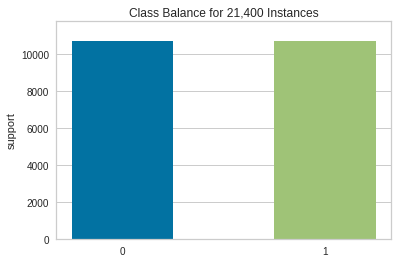

,overall_posneg,ttlCol
0,0,10700
1,1,10700


In [17]:
dps.displayClassBalance(tDf2, myExp.dataPackage.targetColumn, verbose=True)

In [18]:
from xgboost import XGBClassifier
from keras.layers.core import SpatialDropout1D
from keras.layers import Dropout, Dense, Flatten, LSTM, Input, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers.embeddings import Embedding
import keras

print(keras.__version__)
from keras import backend as K
K._get_available_gpus()

2.7.0


2022-01-22 19:57:07.239681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 19:57:07.239783: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 19:57:07.239839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2022-01-22 19:57:07.240557: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[]

In [19]:
###Notes section:
#model = Sequential()
#model.add(LSTM(NumberOfLSTM, return_sequences=True,
#               input_shape=(YourSequenceLenght, YourWord2VecLenght)))
tExp = jarvis.loadExperiment('01_ML1010_GP_XGB_Bert2')
tFeat = tExp.getFinalFeatures()
print (len(tFeat))
print (tFeat[1])

49
c15


In [20]:
from tensorflow.keras.metrics import AUC, Precision, Recall

In [35]:
#tDf2 is sampled down training data

tDf3 = tDf2.copy() 
Y_train = np.array(tDf3[myExp.dataPackage.targetColumn])
X_train = np.array(tDf3[tFeat])

X_test = np.array(myExp.dataPackage.getXTestData(tFeat))
Y_test = np.array(myExp.dataPackage.getYTestData())

print(Y_train.shape)
print(X_train.shape)
EPOCHS=5
VAL_SPLIT=0.1

BATCH_SIZE=100
NUMBER_FEATURES=len(tFeat)

DROPOUT_RATE=0.2
INTERNAL_LAYERS=5
LSTM_OUTPUT_UNITS=5

(21400,)
(21400, 49)


In [22]:
# Neural network
keras.backend.clear_session()

model2 = None
model2 = Sequential()

#model2.add(Input(shape=(NUMBER_FEATURES, 1)))
#model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))

model2.add(LSTM(units=LSTM_OUTPUT_UNITS, 
                input_shape=(NUMBER_FEATURES, 1),
                return_sequences=False
               )
          )
#model2.add(Dropout(DROPOUT_RATE))
#model2.add(Conv1D(filters=LSTM_OUTPUT_UNITS, kernel_size=3, padding='same', activation='relu'))
#model2.add(MaxPooling1D(pool_size=2))
#model2.add(LSTM(units=LSTM_OUTPUT_UNITS))
#model2.add(Dropout(DROPOUT_RATE))


#model2.add(LSTM(units=LSTM_OUTPUT_UNITS))
#model2.add(Dropout(DROPOUT_RATE))

model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
model2.add(Dropout(DROPOUT_RATE))

#model2.add(Dense(LSTM_OUTPUT_UNITS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))

#model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))

#model2.add(Dense(LSTM_OUTPUT_UNITS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))


#softmax is for multiclass
#model2.add(Dense(1, activation='softmax'))
#----
#sigmoid is not for multiclass
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy',
                        'mse',
                        AUC(),
                        Precision(),
                        Recall()
                       ]
              )

history = model2.fit(x=X_train, 
                     y=Y_train, 
                     epochs=EPOCHS, 
                     batch_size=BATCH_SIZE,
                     validation_split=VAL_SPLIT)

Epoch 1/5
193/193 [==============================] - 3s 13ms/step - loss: 0.6739 - accuracy: 0.5641 - mse: 0.2406 - auc: 0.6042 - precision: 0.6559 - recall: 0.0403 - val_loss: 0.8091 - val_accuracy: 0.3491 - val_mse: 0.3065 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.3491
Epoch 2/5
193/193 [==============================] - 2s 10ms/step - loss: 0.6079 - accuracy: 0.6877 - mse: 0.2097 - auc: 0.7375 - precision: 0.6648 - recall: 0.5998 - val_loss: 0.6671 - val_accuracy: 0.7196 - val_mse: 0.2297 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7196
Epoch 3/5
193/193 [==============================] - 2s 10ms/step - loss: 0.5590 - accuracy: 0.7280 - mse: 0.1877 - auc: 0.7886 - precision: 0.6839 - recall: 0.7215 - val_loss: 0.6239 - val_accuracy: 0.7467 - val_mse: 0.2073 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7467
Epoch 4/5
193/193 [==============================] - 2s 11ms/step - loss: 0.5355 - accuracy: 0.7458 - mse: 0.1773 - auc: 0.8

dict_keys(['loss', 'accuracy', 'mse', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_mse', 'val_auc', 'val_precision', 'val_recall'])


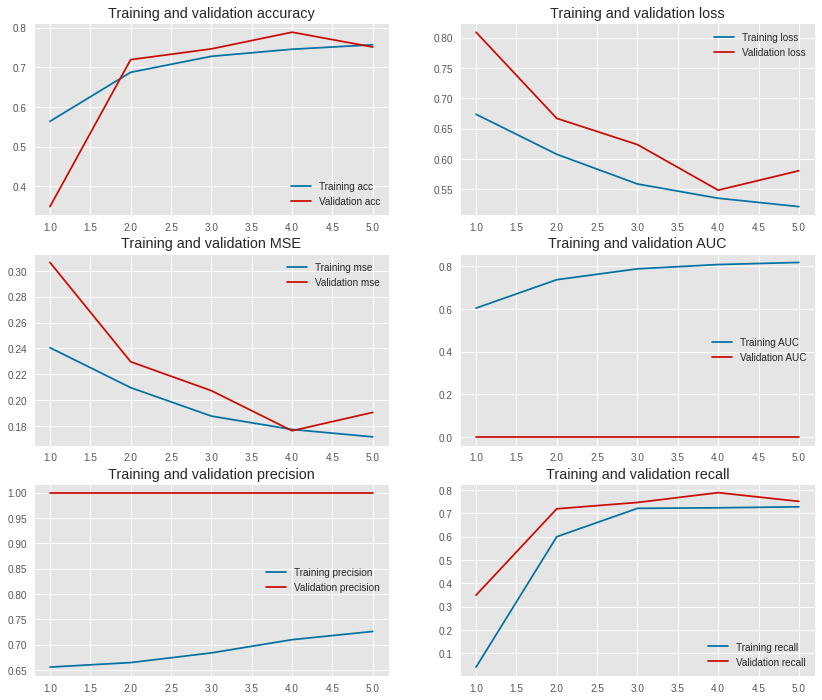

<Figure size 432x288 with 0 Axes>

In [23]:
des.plot_history(history)

In [100]:
print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 5)                 30        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
myExp.setBaseModel(model2)
#myExp.predictBaseModel()
myExp.setFinalModel(model2,
                    finalFeatures=tExp.finalFeatures,
                    finalFeaturesAll=tExp.finalFeaturesAll
                    )


In [101]:
colActual='y_actual'
colPredict='y_pred'
#y_pred = model2.predict(X_test)
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

dfPredict = pd.DataFrame(data=y_pred, columns=[colPredict])
dfPredict[colActual] = Y_test.tolist()
des.printMetrics(data=dfPredict, colActual=colActual, colPredict=colPredict)

Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1: 0.76
CohenKappa: 0.53


In [97]:
importlib.reload(des)

<module 'DataExperimentSupport' from '/home/magni/ML_Root/project_root/utility_files/DataExperimentSupport.py'>

#  Save Experiment

In [102]:
jarvis.saveExperiment(myExp, FILE_NAME)

INFO:tensorflow:Assets written to: ram://c9b62a87-baa4-4f69-adbb-8bed4c62bddd/assets


INFO:tensorflow:Assets written to: ram://c9b62a87-baa4-4f69-adbb-8bed4c62bddd/assets


#  Scratchpad